In [700]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [701]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [702]:
# using random seeds for all pytorch and numpy operations to use the same random numbers all the time
seed = 67
np.random.seed(seed)
torch.manual_seed(seed)

In [703]:
# loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Housing Price prediction/train.csv')


# Seperating inputs and outputs
X = df.drop(columns=['SalePrice', 'Id']) # also removing the 'Id' column
Y = df['SalePrice'].values

# seperating numerical features from categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# spliting the dataset into training and testing subsets respectively 80 and 20 %
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state = 33)


In [704]:
# num_transformer - a pipeline which replaces NaNs with the mean of the column and than scales the data
num_transformer = Pipeline([
    ('num_imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())

])

In [705]:
# cat_transformer - a pipeline which replaces NaNs with the moce of the column and than OneHotEncodes the data
cat_transformer = Pipeline([
    ('cat_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) #ignoring unseen values in validation
    # return dense matrix

])

In [706]:
# preprocessor pipeline that scales numerical values and one hot encodes categorical features
main_preprocessor = ColumnTransformer([

    ('cat_f', cat_transformer, cat_features),
    ('num_f', num_transformer, num_features),
])

In [707]:
# neural network with 2 hidden layers and relu activation functions

class Model(nn.Module):
    def __init__(self, in_features, h1, h2, h3, h4, out_features):

        super().__init__()

        self.layer1 = nn.Linear(in_features, h1)
        self.layer2 = nn.Linear(h1, h2)
        self.layer3 = nn.Linear(h2, h3)
        self.layer4 = nn.Linear(h3, h4)
        self.p=0.2

        self.out = nn.Linear(h4, out_features)



    # forward method with ReLu activation functions
    def forward(self, x):
        x = F.dropout(F.relu(self.layer1(x)),p=self.p)
        x = F.dropout(F.relu(self.layer3(x)),p=self.p)
        x = F.dropout(F.relu(self.layer4(x)),p=self.p)
        x = F.dropout(F.relu(self.layer2(x)), p=self.p)
        x = self.out(x)

        return x


In [708]:
epochs = 6000

# loss cache for main training
losses_train = []

In [709]:
### cross-validation

# parameters for Model class
input_features = 283  #number of features after preprocessing
hidden_layer_1 = 8
hidden_layer_2 = 8
hidden_layer_3 = 8
hidden_layer_4 = 8
output_layer = 1

# caches for losses and R^2
#cv_train_losses = []
val_losses = []
val_R2s = []

# instantiating the model, optimizer and MSE loss
model = Model(input_features, hidden_layer_1, hidden_layer_2, hidden_layer_3, hidden_layer_4, output_layer)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
mse_loss = nn.MSELoss()

In [710]:
###  defining a function for cross validation to track it during training
def cross_validation(X_val, Y_val):
  # preprocessing test data
  X_val = torch.FloatTensor(main_preprocessor.transform(X_val))
  Y_val = torch.FloatTensor(scaler_train_test.transform(Y_val.reshape(-1, 1)))

  # set the model to evaluation mode
  model.eval()

  # prevent gradient calculation while testing
  with torch.no_grad():

      # predict outputs for X_test
      Y_val_pred = model(X_val)

      # calculate the loss
      val_loss = mse_loss(Y_val.squeeze(), Y_val_pred.squeeze())
      val_losses.append(val_loss)
      # calculate R2 for test set
      r2_val = r2_score(Y_val.detach().numpy(), Y_val_pred.squeeze().detach().numpy())
      val_R2s.append(r2_val)

In [711]:
# Training

# preprocessing the training data and converting to torch tensors
X_train = torch.FloatTensor(main_preprocessor.fit_transform(X_train))
scaler_train_test = StandardScaler()
Y_train = torch.FloatTensor(scaler_train_test.fit_transform(Y_train.reshape(-1, 1)))



# training the model on the main "X_train" dataset
for i in range(epochs):


    # setting up the model to training mode
  model.train()

    # making the gradients zero
  optimizer.zero_grad()

    # predict the outputs
  Y_pred = model(X_train)

    # count and cache the loss
  loss = mse_loss(Y_pred.squeeze(), Y_train.squeeze())
  losses_train.append(loss.item())

    # apply backward propagation
  loss.backward()

    # update the parameters
  optimizer.step()


  if i % 100 == 0:
      print(f'Training Epoch: {i} and loss: {loss.item()}')
      # keeping the track of validation losses every 100 epochs
      cross_validation(X_val, Y_val)




# count r^2 for training set
r2_train = r2_score(Y_train.detach().numpy(), Y_pred.squeeze().detach().numpy())

Training Epoch: 0 and loss: 1.0162513256072998
Training Epoch: 100 and loss: 0.6982704997062683
Training Epoch: 200 and loss: 0.5667855739593506
Training Epoch: 300 and loss: 0.4551127254962921
Training Epoch: 400 and loss: 0.4104536771774292
Training Epoch: 500 and loss: 0.36363527178764343
Training Epoch: 600 and loss: 0.32920750975608826
Training Epoch: 700 and loss: 0.27978992462158203
Training Epoch: 800 and loss: 0.3022592067718506
Training Epoch: 900 and loss: 0.29837003350257874
Training Epoch: 1000 and loss: 0.3009147346019745
Training Epoch: 1100 and loss: 0.28001341223716736
Training Epoch: 1200 and loss: 0.2807752192020416
Training Epoch: 1300 and loss: 0.27367305755615234
Training Epoch: 1400 and loss: 0.2462870180606842
Training Epoch: 1500 and loss: 0.2352672964334488
Training Epoch: 1600 and loss: 0.27019739151000977
Training Epoch: 1700 and loss: 0.22127464413642883
Training Epoch: 1800 and loss: 0.2055356204509735
Training Epoch: 1900 and loss: 0.22115129232406616
Tra

In [712]:
cross_validation(X_val, Y_val)
print(f'Val Loss: {val_loss}')

Val Loss: 0.2310134917497635


In [713]:
print(f'Final traning Loss: {losses_train[5999]}')
print(f'Val Loss: {val_loss}')

Final traning Loss: 0.2099078744649887
Val Loss: 0.2310134917497635


In [714]:
print(f'Final traing R2: {r2_train}')
print(f'Val R2: {r2_val}')

Final traing R2: 0.7900921106338501
Val R2: 0.7636382579803467


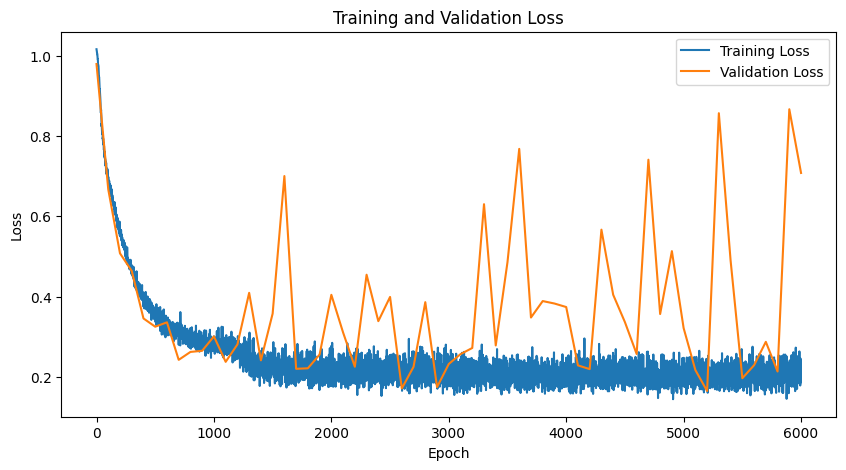

In [715]:
# After the training loop:
plt.figure(figsize=(10, 5))
plt.plot(losses_train, label='Training Loss')

#create X axis for validation losses
X_axis_val = [i*100 for i in range(len(val_losses))]

plt.plot(X_axis_val, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [716]:
#### TESTING
#loading the testing dataset
X_test = pd.read_csv('/content/drive/MyDrive/Housing Price prediction/test.csv')

#removing the 'Id' column
X_test = X_test.drop(columns=['Id'])

# seperating numerical features from categorical features
num_features = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_features = X_test.select_dtypes(include=['object', 'category']).columns.tolist()


# testing

#preprocessing the data
X_test = torch.FloatTensor(main_preprocessor.transform(X_test))

# testing dataset predtiction
Y_test_pred =model(X_test)

# reversing the predicted values to their original scale
Y_test_pred =scaler_train_test.inverse_transform(Y_test_pred.reshape(-1, 1).detach().numpy())

Y_test_pred[:20]

array([[139922.73 ],
       [138965.56 ],
       [166684.75 ],
       [204785.16 ],
       [158326.84 ],
       [165457.45 ],
       [183783.5  ],
       [170385.1  ],
       [186349.25 ],
       [ 86492.02 ],
       [166769.53 ],
       [100689.234],
       [ 82365.01 ],
       [133194.5  ],
       [114698.234],
       [289976.22 ],
       [252250.34 ],
       [281446.1  ],
       [316549.75 ],
       [358508.22 ]], dtype=float32)